In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
# imports
import pprint
import pickle
import glob
import random
from pathlib import Path

import torch
from tqdm.autonotebook import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pytorch3d

from utils import utils
import deformation.losses as def_losses
from utils.datasets import GenerationDataset, ShapenetRendersDataset, ShapenetPointsDataset
from utils.datasets import gen_data_collate
from utils import coords


In [4]:
gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))
cfg_path = "configs/default.yaml"
cfg = utils.load_config(cfg_path, "configs/default.yaml")

In [5]:
def plot_pointcloud(pointcloud):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = pointcloud[:,0]
    y = pointcloud[:,1]
    z = pointcloud[:,2]
    ax.scatter(x,y,z, marker = '.')

In [6]:
generation_dataset = GenerationDataset(cfg)
generation_loader = torch.utils.data.DataLoader(generation_dataset, batch_size=1, shuffle=False, collate_fn=gen_data_collate)

Loading cached generation dataset at caches/generation_dataset_cache_480.pt...


In [12]:
input_batch = generation_dataset[2]

image = input_batch["image"]
mesh_batch = input_batch["mesh"].to(device)
verts_padded = mesh_batch.verts_padded()
print(verts_padded.shape)
pose = input_batch["pose"].to(device)
print(pose)
distance = pose[0]
elevation = pose[1]
azimuth = pose[2]
P = coords.compute_extrinsic_matrix(azimuth, elevation, distance)
P = torch.unsqueeze(P, 0).to(device)
print(P.shape)

#aligned_verts_padded = coords.project_verts(verts_padded, P)
aligned_verts_padded = coords.rotate_verts(P, verts_padded)
print(aligned_verts_padded.shape)

torch.Size([1, 1502, 3])
tensor([  1.0769, 142.1053, 284.2105], device='cuda:0')
torch.Size([1, 4, 4])
torch.Size([1, 1502, 3])


torch.Size([1, 3, 3])
torch.Size([1, 3])
torch.Size([1, 512, 512, 4])


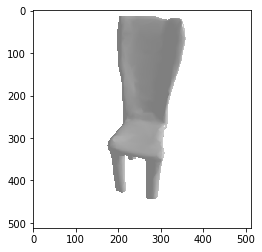

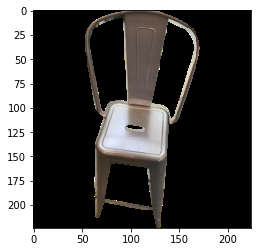

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
R, T = look_at_view_transform(distance, elevation, azimuth)
print(R.shape)
print(T.shape)
mesh_original_render = utils.render_mesh(mesh_batch, R, T, device)
print(mesh_original_render.shape)
plt.imshow(mesh_original_render[0, ..., :3].cpu().numpy())
plt.show()
plt.imshow(image.permute(1,2,0).numpy())

In [14]:
A = R[0].cpu().numpy()
B = T[0].cpu().numpy().reshape(-1,1)
C = np.zeros([3])
D = np.array([1])
P1 = torch.tensor([np.block([[A,B],[C,D]])], dtype=torch.float).to(device)
print(P1)



test_aligned_verts_padded = coords.project_verts(verts_padded, P1)



tensor([[[ 2.4549e-01, -5.9542e-01, -7.6499e-01, -1.4901e-08],
         [-0.0000e+00,  7.8914e-01, -6.1421e-01, -4.8429e-08],
         [ 9.6940e-01,  1.5078e-01,  1.9372e-01,  1.0769e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')
[[ 4.3711388e-03  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  4.3711388e-08 -1.0000000e+00]
 [-0.0000000e+00  1.0000000e+00  4.3711388e-08]]
[[-0.]
 [-0.]
 [ 2.]]


In [52]:
R_target, T_target = look_at_view_transform(eye=torch.tensor([[0.0,0.0,2.0]]))
R_target = R_target[0].cpu().numpy()
T_target = T_target[0].cpu().numpy().reshape(-1,1)
C = np.zeros([3])
D = np.array([1])
P_target =  torch.tensor([np.block([[R_target,T_target],[C,D]])], dtype=torch.float).to(device)
print(P_target)

tensor([[[-1.,  0.,  0., -0.],
         [ 0.,  1.,  0., -0.],
         [ 0.,  0., -1.,  2.],
         [ 0.,  0.,  0.,  1.]]], device='cuda:0')


[[-0.2  1.   0. ]
 [-0.2 -1.   0. ]
 [ 0.2 -1.   0. ]
 [ 0.2  1.   0. ]]
[[ 0.2  1.   1. ]
 [ 0.2 -1.   1. ]
 [-0.2 -1.   1. ]
 [-0.2  1.   1. ]]


<IPython.core.display.Javascript object>


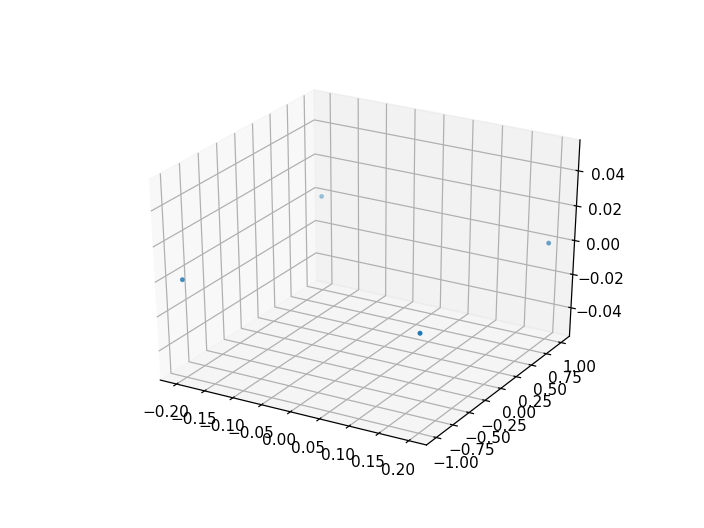

<IPython.core.display.Javascript object>


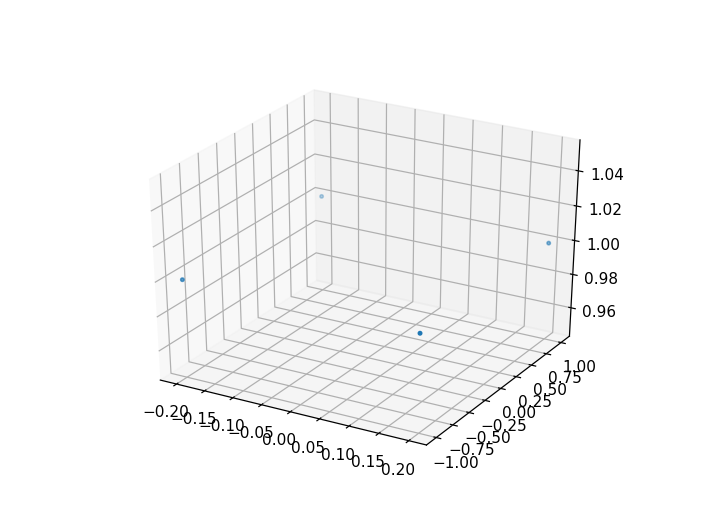

In [47]:
%matplotlib notebook
import matplotlib.pyplot as plt
test = np.array([[[-0.2,1,0],
                  [-0.2,-1,0],
                  [0.2,-1,0],
                  [0.2,1,0]]])
test_tensor = torch.tensor(test, dtype=torch.float).to(device)

projected_test_tensor = coords.project_verts(torch.tensor(test, dtype=torch.float).to(device), P_target)
projected_test = projected_test_tensor.cpu().numpy()
print(test[0])
print(projected_test[0])
plot_pointcloud(test[0])
plot_pointcloud(projected_test[0])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
x = verts_padded.cpu().numpy()[0][:,0]
y = verts_padded.cpu().numpy()[0][:,1]
plt.plot(x,y, '.')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

x = test_aligned_verts_padded.cpu().numpy()[0][:,0]
y = test_aligned_verts_padded.cpu().numpy()[0][:,1]
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(x,y, '.')

In [ ]:
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
plot_pointcloud(verts_padded.cpu().numpy()[0])
plot_pointcloud(aligned_verts_padded.cpu().numpy()[0])